# Imports

In [1]:
#Import libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

In [2]:
# Import file
path = r'/Users/jorisjan/Documents/CareerFoundry/Instacart Basket Analysis'
df_orders_products_all = pd.read_pickle(os.path.join(path, '02 Data', 'Prepared Data', 'orders_products_all.pkl'))

# PII Risk Assessment

In [66]:
df_orders_products_all.dtypes

order_id                   object
user_id                    object
order_number                int64
orders_day_of_week          int64
order_hour_of_day           int64
days_since_prior_order    float64
product_id                  int64
add_to_cart_order           int64
reordered                   int64
product_name               object
aisle_id                    int64
department_id               int64
prices                    float64
price_range_loc            object
busiest_day                object
busiest_days               object
busiest_period_of_day      object
max_order                   int64
loyalty_flag               object
mean_price                float64
spending_flag              object
median_days_spo           float64
regular_flag               object
gender                     object
state                      object
age                         int64
date_joined                object
number_of_dependents        int64
marital_status             object
income        

When dealing with customer data, it's crucial to identify and handle any Personally Identifiable Information (PII) appropriately to maintain privacy and comply with data protection regulations like the GDPR or CCPA.

From the columns in the DataFrame, I've already removed 'First Name' and 'Surnam', which were direct identifiers as they were private information and weren't relevent for my analysis.
Here are some thoughts on other columns that may have security implications:

- 'user_id': may not be directly identifiable information, it's unique to an individual and can become PII when combined with other data. It's important to ensure that this cannot be traced back to an individual without proper authorization
- 'gender', 'state', 'age', 'date_joined', 'number_of_dependents', 'marital_status', and 'income': contain demographic information which could potentially be used to re-identify individuals, especially when combined. But this information is necessary for my analysis and it has been anonymized by removing 'First Name' and 'Surnam'
- order_id: is a unique identifier for orders but should still be treated with caution, especially if it can be linked to individual customers
- other columns related to order details ('order_number', 'orders_day_of_week', etc.), product information ('product_id', 'product_name', etc.), and customer behavior ('loyalty_flag', 'spending_flag', etc.) are less sensitive (once again, unless they can be linked back to PII data)

# Regional segmentation of the data

In [4]:
# Define the mapping of states to regions
regions = {
    'Northeast': ['Maine', 'New Hampshire', 'Vermont', 'Massachusetts', 'Rhode Island', 'Connecticut', 'New York', 'Pennsylvania', 'New Jersey'],
    'Midwest': ['Wisconsin', 'Michigan', 'Illinois', 'Indiana', 'Ohio', 'North Dakota', 'South Dakota', 'Nebraska', 'Kansas', 'Minnesota', 'Iowa', 'Missouri'],
    'South': ['Delaware', 'Maryland', 'District of Columbia', 'Virginia', 'West Virginia', 'North Carolina', 'South Carolina', 'Georgia', 'Florida', 'Kentucky', 'Tennessee', 'Mississippi', 'Alabama', 'Oklahoma', 'Texas', 'Arkansas', 'Louisiana'],
    'West': ['Idaho', 'Montana', 'Wyoming', 'Nevada', 'Utah', 'Colorado', 'Arizona', 'New Mexico', 'Alaska', 'Washington', 'Oregon', 'California', 'Hawaii']
}

# Create a function to map the state to the region
def get_region(state):
    for region, states in regions.items():
        if state in states:
            return region
    return 'Unknown'  # If the state is not found in the regions dictionary

# Apply the function to the 'state' column to create a new 'Region' column
df_orders_products_all['Region'] = df_orders_products_all['state'].apply(get_region)

In [5]:
df_orders_products_all['Region'].value_counts()

Region
South        10791885
West          8292913
Midwest       7597325
Northeast     5722736
Name: count, dtype: int64

### Difference in spending habits between U.S. regions

In [6]:
# Crosstab of the 'Region' and 'spending_flag' columns
spending_habits_by_region = pd.crosstab(df_orders_products_all['Region'], df_orders_products_all['spending_flag'])
print(spending_habits_by_region)

spending_flag  High spender  Low spender
Region                                  
Midwest              155975      7441350
Northeast            108225      5614511
South                209691     10582194
West                 160354      8132559


In [7]:
# Normalize the cross-tabulation by rows to see the proportion of each spending flag within regions
spending_habits_by_region_normalized = pd.crosstab(df_orders_products_all['Region'], df_orders_products_all['spending_flag'], normalize='index')

# Display the normalized cross-tabulation table
print(spending_habits_by_region_normalized)

spending_flag  High spender  Low spender
Region                                  
Midwest            0.020530     0.979470
Northeast          0.018911     0.981089
South              0.019430     0.980570
West               0.019336     0.980664


#### Spending Distribution:
- In each region, the majority (98%) of customers are classified as 'Low spenders'. 'High spender' counts are significantly lower (2%) compared to 'Low spenders' in all regions
- The South region has the highest number of both 'High spenders' (209,691) and 'Low spenders' (10,582,194). This suggests it might be the largest market among the four regions in terms of customer base
- The Northeast region has the lowest number of 'High spenders' (108,225) and 'Low spenders' (5,614,511), indicating it's the smallest market among the four in terms of these spending categories
- The Midwest and West regions have intermediate numbers, with the West slightly leading in both categories

#### Implications for Business Strategy:
- Since the majority of customers across all regions are 'Low spenders', strategies focusing on this segment could be more effective
- The significant market size of the 'Low spender' segment suggests potential for volume-based strategies, like promotions and discounts, to drive sales.
- Despite their smaller numbers, 'High spenders' could represent a valuable segment. Tailored strategies such as premium services or products might be effective for this group.
Regional differences highlight the importance of localized strategies.

# Creation of an exclusion flag for low-activity customers (< 5 orders)

In [8]:
# Step 1: Create an exclusion flag for low-activity customers
df_orders_products_all['exclusion_flag'] = df_orders_products_all['order_number'] < 5

In [9]:
# Step 2: Filter out low-activity customers
df_high_activity_customers = df_orders_products_all[df_orders_products_all['exclusion_flag'] == False]

In [10]:
# Step 3: Export the filtered DataFrame to a Pickle file
df_high_activity_customers.to_pickle(os.path.join(path, '02 Data', 'Prepared Data', 'high_activity_customers.pkl'))

In [11]:
df_orders_products_all.shape

(32404859, 32)

In [12]:
df_high_activity_customers.shape

(24414877, 32)

# Customer profiling 

### Age Segmentation

In [13]:
# 'Young adult' = Users younger than 26
df_high_activity_customers.loc[df_high_activity_customers['age'] < 26, 'age_profile'] = 'Young adult'

/var/folders/dt/sqcrp8bd1cx8p99whrf_c9wr0000gn/T/ipykernel_56117/2510850680.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_high_activity_customers.loc[df_high_activity_customers['age'] < 26, 'age_profile'] = 'Young adult'


In [14]:
# 'Adult' = Users 26 and older but younger than 65 
df_high_activity_customers.loc[(df_high_activity_customers['age'] < 65) & (df_high_activity_customers['age'] >= 26), 'age_profile'] = 'Adult' 

In [15]:
# 'Retired' = Users 65 and older
df_high_activity_customers.loc[df_high_activity_customers['age'] >= 65, 'age_profile'] = 'Retired'

In [16]:
# Count values
df_high_activity_customers['age_profile'].value_counts(dropna = False)

age_profile
Adult          14908717
Retired         6458450
Young adult     3047710
Name: count, dtype: int64

In [17]:
#Check flags
df_high_activity_customers.groupby('age_profile').agg({'age' : ['min', 'max']})

age    
            min max
age_profile        
Adult        26  64
Retired      65  81
Young adult  18  25

Results are as expected

### Income Segmentation

In [18]:
df_high_activity_customers['income'].describe()

count    2.441488e+07
mean     9.989505e+04
std      4.333357e+04
min      2.590300e+04
25%      6.752400e+04
50%      9.683600e+04
75%      1.281600e+05
max      5.939010e+05
Name: income, dtype: float64

In [19]:
# Income Segmentation
income_first_quartile = df_high_activity_customers['income'].quantile(0.25)
income_fourth_quartile = df_high_activity_customers['income'].quantile(0.75)

def income_segment(income):
    if income <= income_first_quartile:
        return 'Low Income'
    elif income >= income_fourth_quartile:
        return 'High Income'
    else:
        return 'Middle Income'

df_high_activity_customers['income_profile'] = df_high_activity_customers['income'].apply(income_segment)

/var/folders/dt/sqcrp8bd1cx8p99whrf_c9wr0000gn/T/ipykernel_56117/3062308528.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_high_activity_customers['income_profile'] = df_high_activity_customers['income'].apply(income_segment)


In [20]:
# Count values
df_high_activity_customers['income_profile'].value_counts(dropna = False)

income_profile
Middle Income    12206778
High Income       6104365
Low Income        6103734
Name: count, dtype: int64

In [21]:
#Check flags
df_high_activity_customers.groupby('income_profile').agg({'income' : ['min', 'max']})

income        
                   min     max
income_profile                
High Income     128160  593901
Low Income       25903   67524
Middle Income    67526  128157

Results are as expected

### Dependents Segmentation

In [22]:
# 'Without Kids' = =0 dependent
# 'With Kids' = >0 dependent(s)

result = []

for value in df_high_activity_customers["number_of_dependents"]:
  if value == 0:
    result.append("Without Kids")
  else:
    result.append("With Kids")

In [23]:
df_high_activity_customers['dependents_profile'] = result

/var/folders/dt/sqcrp8bd1cx8p99whrf_c9wr0000gn/T/ipykernel_56117/330768139.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_high_activity_customers['dependents_profile'] = result


## Creation of the profiles

In [24]:
#Customer profiling based on created segmentations
df_high_activity_customers['customer_profile'] = df_high_activity_customers['age_profile'] + '_' + df_high_activity_customers['dependents_profile'] + '_' + df_high_activity_customers['income_profile']

/var/folders/dt/sqcrp8bd1cx8p99whrf_c9wr0000gn/T/ipykernel_56117/792527469.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_high_activity_customers['customer_profile'] = df_high_activity_customers['age_profile'] + '_' + df_high_activity_customers['dependents_profile'] + '_' + df_high_activity_customers['income_profile']


# Distribution of profiles

In [25]:
profile_distribution = df_high_activity_customers['customer_profile'].value_counts(dropna = False)

In [26]:
profile_distribution

customer_profile
Adult_With Kids_Middle Income             5567311
Adult_With Kids_Low Income                2906450
Adult_With Kids_High Income               2672191
Retired_With Kids_Middle Income           2371199
Retired_With Kids_High Income             1865429
Adult_Without Kids_Middle Income          1859961
Young adult_With Kids_Middle Income       1223917
Young adult_With Kids_Low Income          1046051
Adult_Without Kids_Low Income              982955
Adult_Without Kids_High Income             919849
Retired_Without Kids_Middle Income         791770
Retired_With Kids_Low Income               627461
Retired_Without Kids_High Income           608196
Young adult_Without Kids_Middle Income     392620
Young adult_Without Kids_Low Income        346422
Retired_Without Kids_Low Income            194395
Young adult_With Kids_High Income           29866
Young adult_Without Kids_High Income         8834
Name: count, dtype: int64

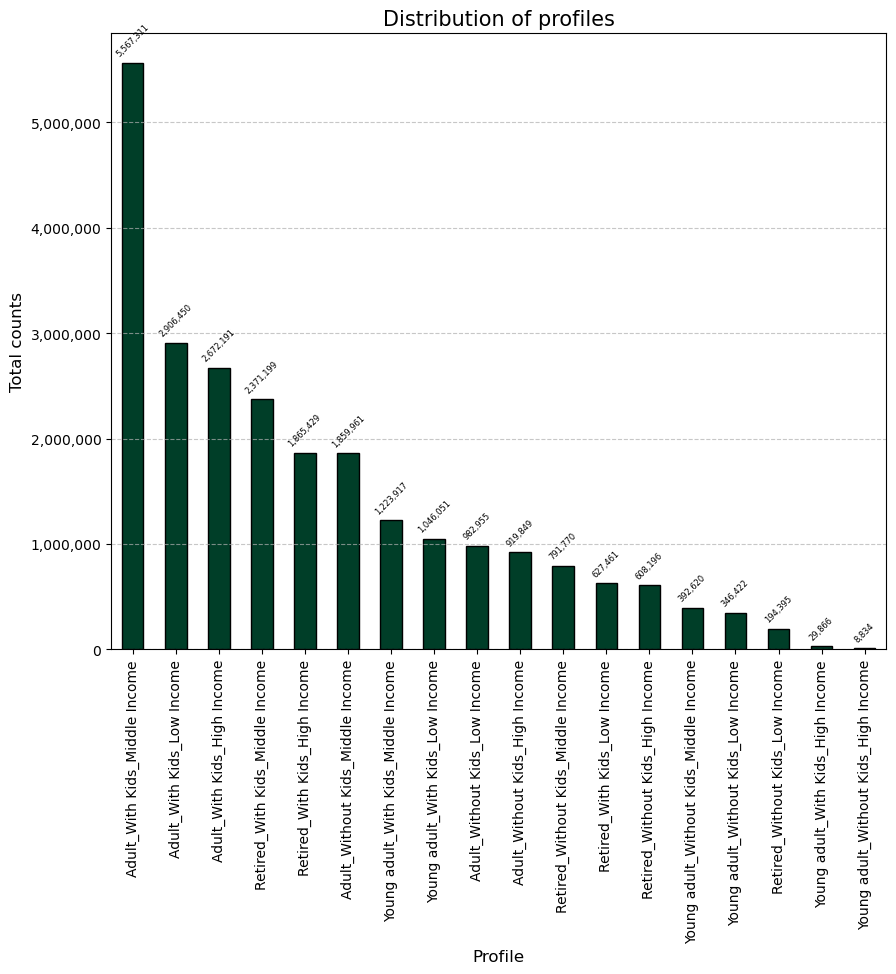

In [27]:
# Create a bar chart to visualize profile distribution
from matplotlib.ticker import FuncFormatter
def millions_formatter(x, pos):
    return '{:,}'.format(int(x))
plt.figure(figsize=(10, 8))
bar_profile_distribution = profile_distribution.plot.bar(color='#003E28', edgecolor='black')

plt.title('Distribution of profiles', fontsize=15)
plt.xlabel('Profile', fontsize=12)
plt.ylabel('Total counts', fontsize=12)
plt.xticks(rotation=90)
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions_formatter))
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of each bar
for bar in bar_profile_distribution.patches:
    height = bar.get_height()
    label = '{:,}'.format(int(height))
    plt.annotate(label, 
                 (bar.get_x() + bar.get_width() / 2, height), 
                 ha='center',
                 xytext=(0, 5), textcoords='offset points', fontsize=6, rotation=45)

The classifications is based on:
- Age: Categories include 'Adult', 'Young adult', and 'Retired', indicating different life stages.
- Family status: Indicated by the presence or absence of 'Kids', suggesting family compositions.
- Income level: Distinguished as 'Low income', 'Middle income', and 'High income', showing economic status.
- There is a Total of 18 Categories.

Their distribution indicates that:
- "Adult with kids & middle income" is the most common profile with the highest total count.
- "Adult with kids & low income" follows as the second most common profile.
- "Adult with kids & high income" is the third, suggesting that adults with kids across all income levels are a significant portion of the demographic.
- The least common profiles include "Young adult with or without kids & high income" and "Retired without kids & low income."

This distribution can inform targeted marketing strategies, product development, and service offerings tailored to the most prominent customer profiles.

# Max, mean, and min variables on a customer-profile level for usage frequency and expenditure.

In [28]:
# Group by 'customer_profile'
grouped = df_high_activity_customers.groupby('customer_profile')

# Aggregate max, mean, and min for 'days_since_prior_order' and 'prices'
aggregated_data = grouped.agg({
    'days_since_prior_order': ['max', 'mean', 'min'],
    'prices': ['max', 'mean', 'min']})

In [29]:
aggregated_data

days_since_prior_order                  \
                                                          max       mean  min   
customer_profile                                                                
Adult_With Kids_High Income                              30.0  10.122896  0.0   
Adult_With Kids_Low Income                               30.0  10.192160  0.0   
Adult_With Kids_Middle Income                            30.0  10.068031  0.0   
Adult_Without Kids_High Income                           30.0   9.908056  0.0   
Adult_Without Kids_Low Income                            30.0  10.133022  0.0   
Adult_Without Kids_Middle Income                         30.0  10.026901  0.0   
Retired_With Kids_High Income                            30.0  10.003739  0.0   
Retired_With Kids_Low Income                             30.0  10.231731  0.0   
Retired_With Kids_Middle Income                          30.0  10.099099  0.0   
Retired_Without Kids_High Income                         30.0  10.008256  0.0   
Retired_Without Kids_Low Income                          30.0  10.535369  0.0   
Retired_Without Kids_Middle Income                       30.0  10.002545  0.0   
Young adult_With Kids_High Income                        30.0   9.095359  0.0   
Young adult_With Kids_Low Income                         30.0  10.207384  0.0   
Young adult_With Kids_Middle Income                      30.0   9.877479  0.0   
Young adult_Without Kids_High Income                     30.0   9.403328  0.0   
Young adult_Without Kids_Low Income                      30.0  10.192805  0.0   
Young adult_Without Kids_Middle Income                   30.0  10.303507  0.0   

                                       prices                 
                                          max      mean  min  
customer_profile                                              
Adult_With Kids_High Income              25.0  7.947227  1.0  
Adult_With Kids_Low Income               25.0  7.339784  1.0  
Adult_With Kids_Middle Income            25.0  7.948915  1.0  
Adult_Without Kids_High Income           25.0  7.926603  1.0  
Adult_Without Kids_Low Income            25.0  7.338673  1.0  
Adult_Without Kids_Middle Income         25.0  7.958764  1.0  
Retired_With Kids_High Income            25.0  7.959464  1.0  
Retired_With Kids_Low Income             25.0  6.721225  1.0  
Retired_With Kids_Middle Income          25.0  7.946644  1.0  
Retired_Without Kids_High Income         25.0  7.945514  1.0  
Retired_Without Kids_Low Income          25.0  6.740133  1.0  
Retired_Without Kids_Middle Income       25.0  7.957388  1.0  
Young adult_With Kids_High Income        25.0  7.814745  1.0  
Young adult_With Kids_Low Income         25.0  7.600002  1.0  
Young adult_With Kids_Middle Income      25.0  7.949753  1.0  
Young adult_Without Kids_High Income     25.0  7.855647  1.0  
Young adult_Without Kids_Low Income      25.0  7.583633  1.0  
Young adult_Without Kids_Middle Income   25.0  7.938020  1.0

In [30]:
# Flatten the MultiIndex on columns
aggregated_data.columns = ['_'.join(col).strip() for col in aggregated_data.columns.values]

# Rename columns for clarity
aggregated_data.rename(columns={
    'days_since_prior_order_max': 'Max Days Since Last Order',
    'days_since_prior_order_mean': 'Average Days Since Last Order',
    'days_since_prior_order_min': 'Min Days Since Last Order',
    'prices_max': 'Max Price Paid',
    'prices_mean': 'Average Price Paid',
    'prices_min': 'Min Price Paid'
}, inplace=True)

In [31]:
aggregated_data

,Max Days Since Last Order,Average Days Since Last Order,Min Days Since Last Order,Max Price Paid,Average Price Paid,Min Price Paid
customer_profile,,,,,,
Adult_With Kids_High Income,30.0,10.122896,0.0,25.0,7.947227,1.0
Adult_With Kids_Low Income,30.0,10.192160,0.0,25.0,7.339784,1.0
Adult_With Kids_Middle Income,30.0,10.068031,0.0,25.0,7.948915,1.0
Adult_Without Kids_High Income,30.0,9.908056,0.0,25.0,7.926603,1.0
Adult_Without Kids_Low Income,30.0,10.133022,0.0,25.0,7.338673,1.0
Adult_Without Kids_Middle Income,30.0,10.026901,0.0,25.0,7.958764,1.0
Retired_With Kids_High Income,30.0,10.003739,0.0,25.0,7.959464,1.0
Retired_With Kids_Low Income,30.0,10.231731,0.0,25.0,6.721225,1.0
Retired_With Kids_Middle Income,30.0,10.099099,0.0,25.0,7.946644,1.0


# Region Analysis

### What are the Top 3 customer profiles in each regions?

In [32]:
#Group by 'region' and 'customer_profile'
region_profile_counts = df_high_activity_customers.groupby(['Region', 'customer_profile']).size().reset_index(name='customer_profile_count')

#Sort profiles within each region by count in descending order
sorted_customers_profiles = region_profile_counts.sort_values(by=['Region', 'customer_profile_count'], ascending=[True, False])

#Filter the top 3 profiles per region
top3_profiles_per_region = sorted_customers_profiles.groupby('Region').head(3)

top3_profiles_per_region

,Region,customer_profile,customer_profile_count
2,Midwest,Adult_With Kids_Middle Income,1281492
1,Midwest,Adult_With Kids_Low Income,681160
0,Midwest,Adult_With Kids_High Income,649223
20,Northeast,Adult_With Kids_Middle Income,975495
19,Northeast,Adult_With Kids_Low Income,517468
18,Northeast,Adult_With Kids_High Income,476622
38,South,Adult_With Kids_Middle Income,1869686
37,South,Adult_With Kids_Low Income,970065
36,South,Adult_With Kids_High Income,860225
56,West,Adult_With Kids_Middle Income,1440638


### Visualization

/var/folders/dt/sqcrp8bd1cx8p99whrf_c9wr0000gn/T/ipykernel_56117/491621748.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top3_profiles_per_region.sort_values(by=['Region', 'customer_profile_count'], ascending=[True, False], inplace=True)


<Figure size 1200x800 with 0 Axes>

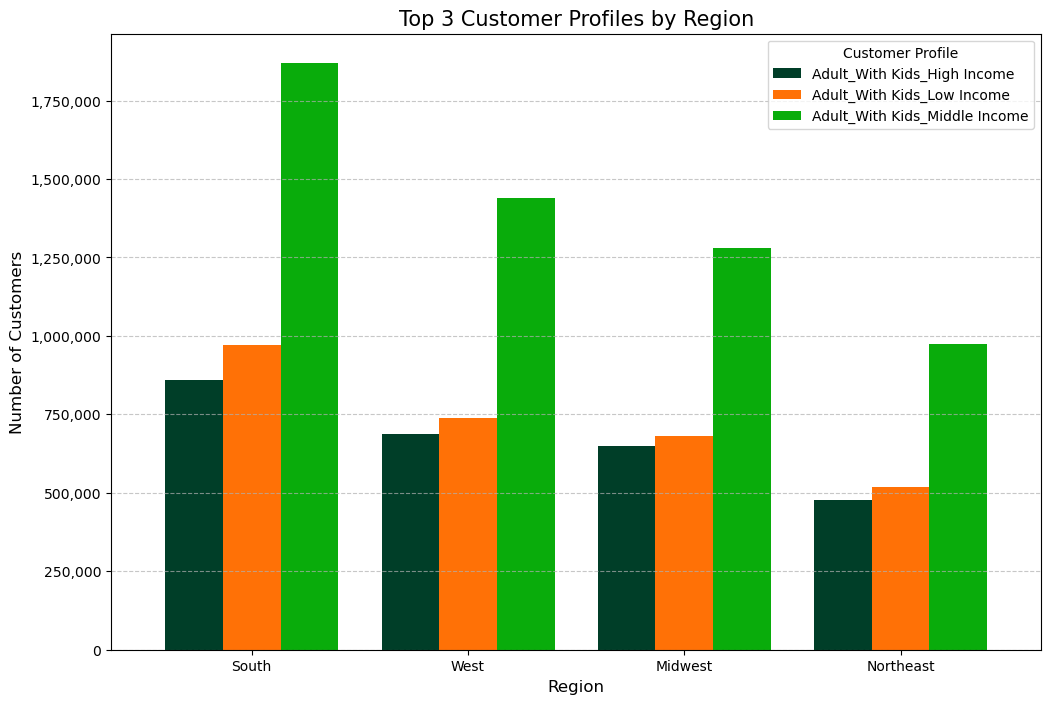

In [33]:
# Sorting the customer profiles within each region in descending order
top3_profiles_per_region.sort_values(by=['Region', 'customer_profile_count'], ascending=[True, False], inplace=True)

# Pivot the data for plotting
pivot_df = top3_profiles_per_region.pivot(index='Region', columns='customer_profile', values='customer_profile_count')

# Sort regions based on total count in descending order
pivot_df['total_count'] = pivot_df.sum(axis=1)
pivot_df.sort_values(by='total_count', ascending=False, inplace=True)
pivot_df.drop(columns='total_count', inplace=True)

# Plotting the bar chart
plt.figure(figsize=(12, 8))

# Create a grouped bar chart
bar_top3_profiles_per_region = pivot_df.plot(kind='bar', color=['#003E28', '#FF7106', '#09AC0B'], figsize=(12, 8), width=0.8)

plt.title('Top 3 Customer Profiles by Region', fontsize=15)
plt.xlabel('Region', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Customer Profile', loc='upper right')
bar_top3_profiles_per_region.yaxis.set_major_formatter(FuncFormatter(millions_formatter))
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

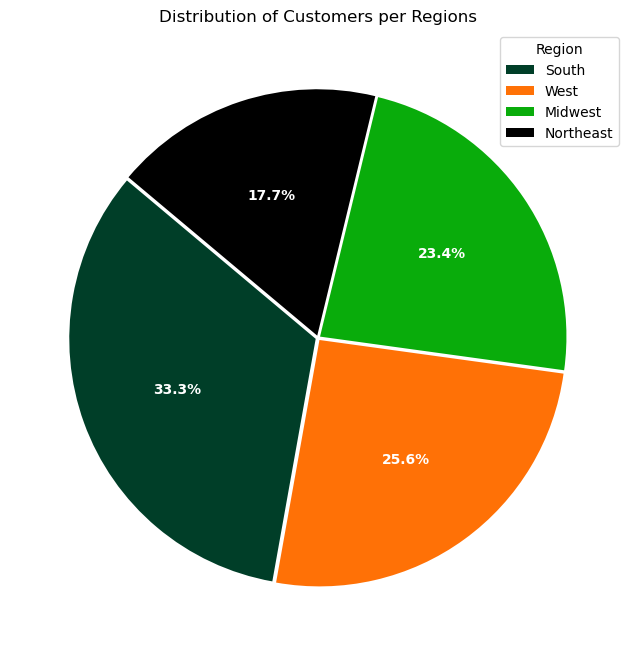

In [47]:
explode = (0.01, 0.01, 0.01, 0.01)
textprops = {"color":"white", "weight":"bold"}  # setting text properties for labels

# Calculate the distribution of marital status
region_counts = df_high_activity_customers['Region'].value_counts()

# Define colors for each region
colors = {'South': '#003E28', 'West': '#FF7106', 'Midwest': '#09AC0B', 'Northeast': 'black'}

# Match colors to the index of region
pie_colors = [colors[status] for status in region_counts.index]

# Create pie chart
plt.figure(figsize=(8, 8))
plt.pie(region_counts, labels=region_counts.index, autopct='%1.1f%%', colors=pie_colors, startangle=140, explode=explode, textprops=textprops)
plt.legend(title='Region', loc='upper right')
plt.title('Distribution of Customers per Regions')
plt.savefig(os.path.join(path, '04 Analysis','Visualizations', 'pie_regions.png'))
plt.show()

/Users/jorisjan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/jorisjan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


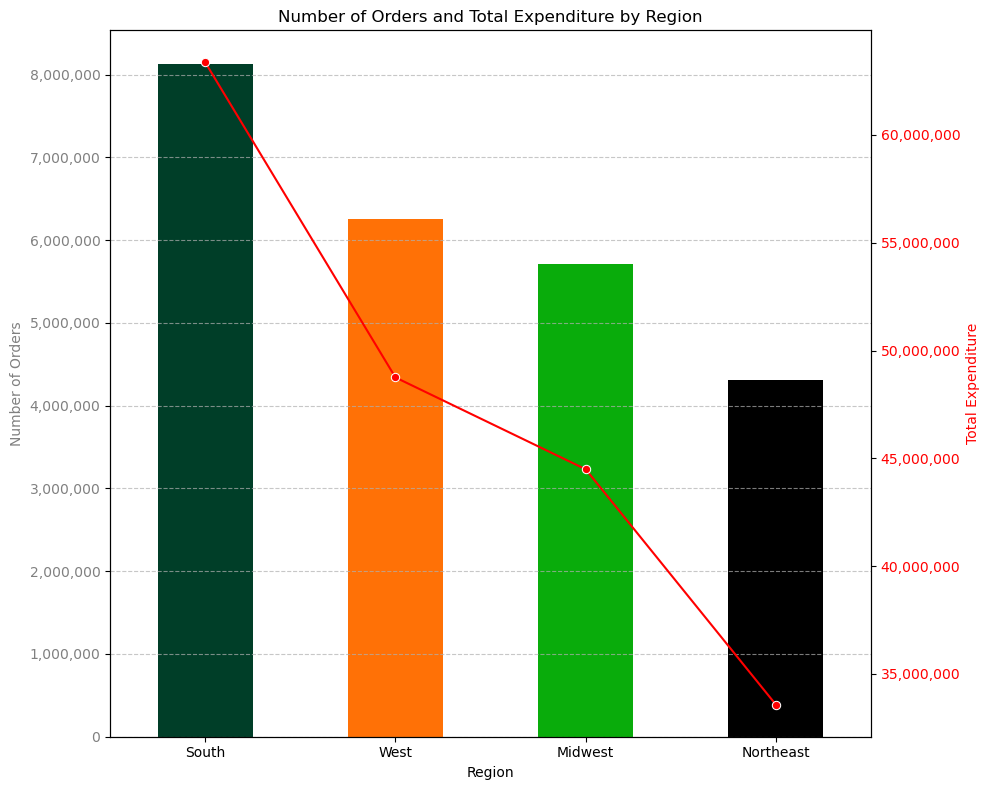

In [48]:
# Define the order of regions
region_order = ['South', 'West', 'Midwest', 'Northeast']

# Calculate the counts by region and reindex to the specified order
region_counts = df_high_activity_customers['Region'].value_counts().reindex(region_order)

# Calculate the sum of prices by region and reindex to the specified order
sum_prices_by_region = df_high_activity_customers.groupby('Region')['prices'].sum().reindex(region_order)

# Set the color mapping for regions
colors = {'South': '#003E28', 'West': '#FF7106', 'Midwest': '#09AC0B', 'Northeast': 'black'}

# Create the bar chart
fig, ax1 = plt.subplots(figsize=(10, 8))
region_counts.plot(kind='bar', color=[colors[region] for region in region_order], ax=ax1)
ax1.set_xlabel('Region')
ax1.set_ylabel('Number of Orders', color='gray')
ax1.tick_params(axis='y', labelcolor='gray')
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions_formatter))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=0)

# Create a secondary y-axis for the line chart
ax2 = ax1.twinx()

# Plot the line chart
sns.lineplot(x=region_order, y=sum_prices_by_region, color='red', marker='o', ax=ax2)
ax2.set_ylabel('Total Expenditure', color='red')
ax2.tick_params(axis='y', labelcolor='red')
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions_formatter))

# Final touches
plt.title('Number of Orders and Total Expenditure by Region')
fig.tight_layout()  # To ensure the secondary y-label is not cut off

# Show the plot
plt.savefig(os.path.join(path, '04 Analysis','Visualizations', 'orders_expenditure_regions.png'))
plt.show()

'The ordering trend decreases from South to Northeast, with the West and Midwest falling in between, in that order.

If I calculate the average expenditure per order for each region, here is what I find:
- South: $84107910.4 / 10791885 orders = $7.79 per order
- West: $64595126.7 / 8292913 orders = $7.79 per order
- Midwest: $59192977.7 / 7597325 orders = $7.79 per order
- Northeast: $44530105.8 / 5722736 orders = $7.78 per order
The average expenditure per order is very consistent across all regions, hovering around $7.78-$7.79, with a negligible difference between the Northeast and the other regions. This uniformity in average spending per order suggests that while the total number of orders and total expenditure varies by region, the spending habit per transaction is quite stable across the regions.

Conclusion: Customers in the South order more and spend more in total, but when it comes to individual orders, customers across all regions spend roughly the same amount on average. This implies that the differences in ordering habits based on customer's region are more about the volume of orders rather than the amount spent per order.

# Customer Profiles and Departments

### What is the Top customer profile for each department?

In [34]:
# Mapping of department_id to department names
department_map = {1: 'frozen', 2: 'other', 3: 'bakery', 4: 'produce', 5: 'alcohol', 6: 'international', 7: 'beverages', 8: 'pets', 9: 'dry goods pasta', 10: 'bulk', 11: 'personal care', 12: 'meat seafood', 13: 'pantry', 14: 'breakfast', 15: 'canned goods', 16: 'dairy eggs', 17: 'household', 18: 'babies', 19: 'snacks', 20: 'deli', 21: 'missing'}

# Group by 'department_id' and 'customer_profile', then sum the 'prices' spent
profile_spend_per_department = df_high_activity_customers.groupby(['department_id', 'customer_profile'])['prices'].sum().reset_index(name='total_spent')

# Sort the results to find the top spender profile for each department
sorted_spend_profiles_per_department = profile_spend_per_department.sort_values(by=['department_id', 'total_spent'], ascending=[True, False])

# Drop duplicate department_ids, keeping the top spender profile (which is now first after sorting)
top_spender_profile_per_department = sorted_spend_profiles_per_department.drop_duplicates(subset='department_id')

# Map the department IDs to names
top_spender_profile_per_department['department_name'] = top_spender_profile_per_department['department_id'].map(department_map)

# Select the columns to display
top_spender_profile_per_department = top_spender_profile_per_department[['department_name', 'customer_profile', 'total_spent']]

# Reset index for clean output
top_spender_profile_per_department.reset_index(drop=True, inplace=True)

# Display the results
print(top_spender_profile_per_department)

    department_name               customer_profile  total_spent
0            frozen  Adult_With Kids_Middle Income    2934913.8
1             other  Adult_With Kids_Middle Income      44001.7
2            bakery  Adult_With Kids_Middle Income    1607722.2
3           produce  Adult_With Kids_Middle Income   13643868.7
4           alcohol  Adult_With Kids_Middle Income     194825.2
5     international  Adult_With Kids_Middle Income     363589.7
6         beverages  Adult_With Kids_Middle Income    3450531.2
7              pets  Adult_With Kids_Middle Income     128469.3
8   dry goods pasta  Adult_With Kids_Middle Income    1110679.3
9              bulk  Adult_With Kids_Middle Income      51949.6
10    personal care  Adult_With Kids_Middle Income     620504.8
11     meat seafood  Adult_With Kids_Middle Income    2092525.2
12           pantry  Adult_With Kids_Middle Income    2613803.0
13        breakfast  Adult_With Kids_Middle Income     939554.1
14     canned goods  Adult_With Kids_Mid

/var/folders/dt/sqcrp8bd1cx8p99whrf_c9wr0000gn/T/ipykernel_56117/35994326.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_spender_profile_per_department['department_name'] = top_spender_profile_per_department['department_id'].map(department_map)


Customer Profiles by Region:

- The profile distribution across regions is consistent, with 'Adult_With Kids_Middle Income' being the most prevalent group. This profile appears to dominate in all regions, indicating that middle-income adults with children are a significant market for Instacart.
- 'Adult_With Kids_High Income' and 'Adult_With Kids_Low Income' also show considerable numbers but are less dominant than the middle-income group.

### Find the most profitable departements 

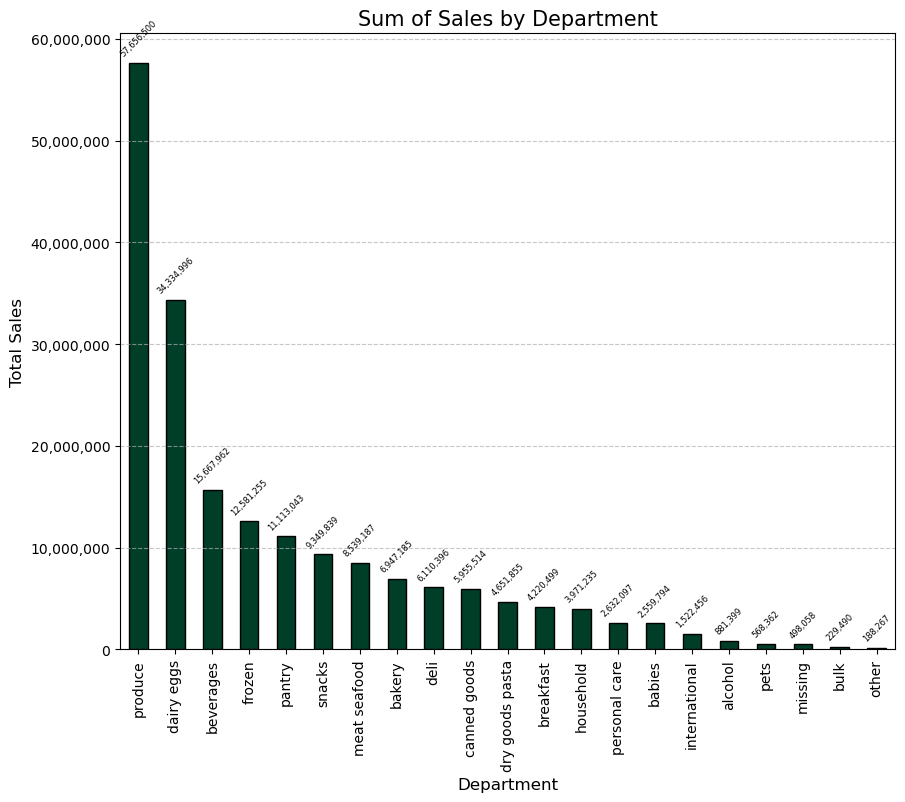

In [35]:
# Create a bar chart to identify profitable categories
# Create a grouped DataFrame by department_id and sum up the prices
department_sales = df_high_activity_customers.groupby('department_id')['prices'].sum()

# Sort the sales from more profitable to less
department_sales_sorted = department_sales.sort_values(ascending=False)

# Map the department_id to names for better readability
department_sales_sorted.index = department_sales_sorted.index.map(department_map)

# Create the bar chart
from matplotlib.ticker import FuncFormatter
def millions_formatter(x, pos):
    return '{:,}'.format(int(x))
plt.figure(figsize=(10, 8))
bar_department_sales = department_sales_sorted.plot.bar(color='#003E28', edgecolor='black')

plt.title('Sum of Sales by Department', fontsize=15)
plt.xlabel('Department', fontsize=12)
plt.ylabel('Total Sales', fontsize=12)
plt.xticks(rotation=90)
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions_formatter))
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of each bar
for bar in bar_department_sales.patches:
    height = bar.get_height()
    label = '{:,}'.format(int(height))
    plt.annotate(label, 
                 (bar.get_x() + bar.get_width() / 2, height), 
                 ha='center',
                 xytext=(0, 5), textcoords='offset points', fontsize=6, rotation=45)

'- Produce - Leading significantly with total sales of nearly 60 million.

- Dairy/Eggs - Following with total sales of over 30 million.

- Beverages - The third highest, with total sales around 15 million.

- Frozen - The fourth in ranking, with sales also around 15 million but slightly less than beverages.

- Pantry - Fifth, with sales slightly under 15 million.

These departments are the most frequented by customers, with Produce and Dairy/Eggs being the most dominant in terms of sales volume.er profiles.

In [36]:
# Filter the data for top 5 departments
top5_departments = [4, 16, 7, 1, 13]
selected_profile_spend = profile_spend_per_department[profile_spend_per_department['department_id'].isin(top5_departments)]

# Sort the results within each department by total spent
sorted_selected_profiles = selected_profile_spend.sort_values(by=['department_id', 'total_spent'], ascending=[True, False])

# Group by 'department_id' and get the top 3 spender profiles
top3_profiles_by_department = sorted_selected_profiles.groupby('department_id').head(3)

# Map the department IDs to names
top3_profiles_by_department['department_name'] = top3_profiles_by_department['department_id'].map(department_map)

# Order the results by the specified department order
top3_profiles_by_department['dept_order'] = pd.Categorical(
    top3_profiles_by_department['department_id'],
    categories=top5_departments,
    ordered=True
)
top3_profiles_by_department.sort_values(by='dept_order', inplace=True)

# Select the columns to display
top3_profiles_by_department = top3_profiles_by_department[['department_name', 'customer_profile', 'total_spent']]

# Reset index for clean output
top3_profiles_by_department.reset_index(drop=True, inplace=True)

# Display the results
print(top3_profiles_by_department)

   department_name               customer_profile  total_spent
0          produce  Adult_With Kids_Middle Income   13643868.7
1          produce    Adult_With Kids_High Income    6432752.6
2          produce     Adult_With Kids_Low Income    6221442.7
3       dairy eggs  Adult_With Kids_Middle Income    8087258.5
4       dairy eggs    Adult_With Kids_High Income    3859122.1
5       dairy eggs     Adult_With Kids_Low Income    3707506.8
6        beverages  Adult_With Kids_Middle Income    3450531.2
7        beverages     Adult_With Kids_Low Income    1996023.7
8        beverages    Adult_With Kids_High Income    1684498.3
9           frozen  Adult_With Kids_Middle Income    2934913.8
10          frozen    Adult_With Kids_High Income    1426281.4
11          frozen     Adult_With Kids_Low Income    1378986.9
12          pantry  Adult_With Kids_Middle Income    2613803.0
13          pantry    Adult_With Kids_High Income    1257061.0
14          pantry     Adult_With Kids_Low Income    12

/var/folders/dt/sqcrp8bd1cx8p99whrf_c9wr0000gn/T/ipykernel_56117/4198792149.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top3_profiles_by_department['department_name'] = top3_profiles_by_department['department_id'].map(department_map)
/var/folders/dt/sqcrp8bd1cx8p99whrf_c9wr0000gn/T/ipykernel_56117/4198792149.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top3_profiles_by_department['dept_order'] = pd.Categorical(
/var/folders/dt/sqcrp8bd1cx8p99whrf_c9wr0000gn/T/ipykernel_56117/4198792149.py:2

<Figure size 1400x1000 with 0 Axes>

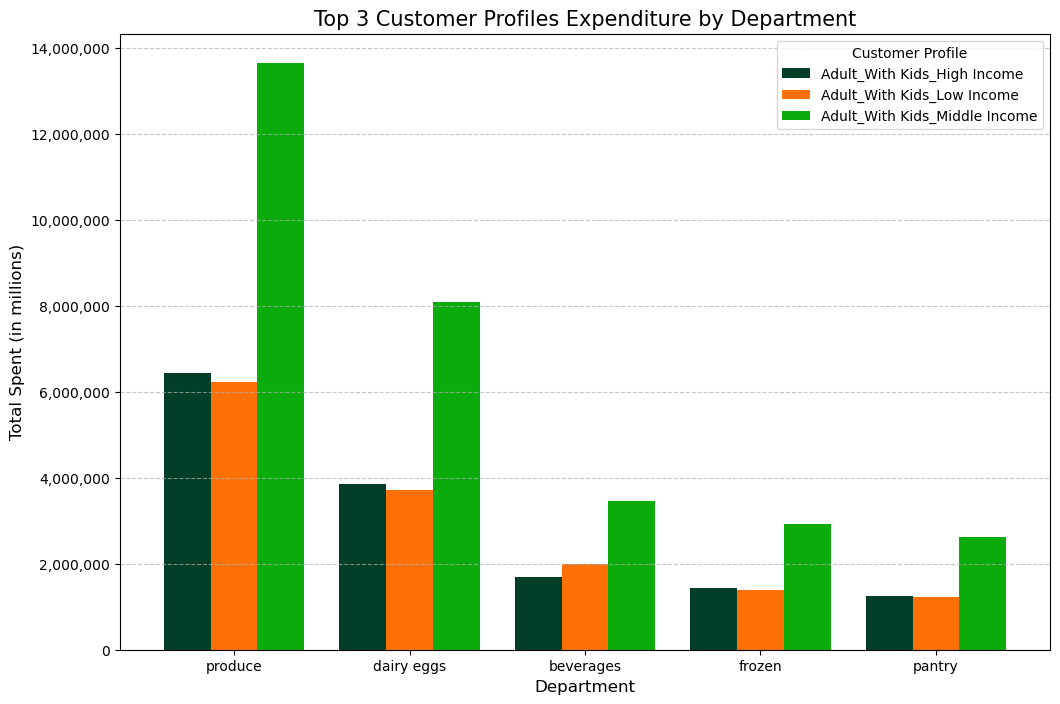

In [37]:
# Pivot the data for plotting
pivot_df = top3_profiles_by_department.pivot(index='department_name', columns='customer_profile', values='total_spent')

# Sort departments based on total count in descending order
pivot_df['total_spent'] = pivot_df.sum(axis=1)
pivot_df.sort_values(by='total_spent', ascending=False, inplace=True)
pivot_df.drop(columns='total_spent', inplace=True)

# Plotting the bar chart
plt.figure(figsize=(14, 10))

# Create a grouped bar chart
bar_top3_profiles_per_department = pivot_df.plot(kind='bar', color=['#003E28', '#FF7106', '#09AC0B'], figsize=(12, 8), width=0.8)

plt.title('Top 3 Customer Profiles Expenditure by Department', fontsize=15)
plt.xlabel('Department', fontsize=12)
plt.ylabel('Total Spent (in millions)', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Customer Profile', loc='upper right')
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions_formatter))
plt.grid(axis='y', linestyle='--', alpha=0.7)


plt.show()

The analysis focuses on the top three customer profiles who contribute most to sales. The departments that these profiles spend the most on include 'produce', 'dairy eggs', 'beverages', 'frozen', and 'pantry', indicating these are popular categories among the higher spending profiles. This could be reflective of routine shopping needs or a preference for fresh and staple foods.

In [38]:
# Step 1: Group by 'department_id', 'Region', and 'customer_profile', then sum the expenditure
grouped_data = df_high_activity_customers.groupby(['department_id', 'Region', 'customer_profile'])['prices'].sum().reset_index(name='total_spent')

# Step 2: Map 'department_id' to department names
grouped_data['department_name'] = grouped_data['department_id'].map(department_map)

# We are interested in the top 3 customer profiles for the following departments
selected_departments = [4, 16, 7, 1, 13]

# Filter out the relevant departments
filtered_data = grouped_data[grouped_data['department_id'].isin(selected_departments)]

# Sort the profiles within each department-region combination by total spent
sorted_profiles = filtered_data.sort_values(by=['department_id', 'Region', 'total_spent'], ascending=[True, True, False])

# Step 3: Pivot the result
# For each department and region, we will have the total expenditure for the top 3 profiles
pivot_df = sorted_profiles.pivot_table(index=['department_name', 'Region'], 
                                       columns='customer_profile', 
                                       values='total_spent', 
                                       aggfunc='sum', 
                                       fill_value=0)

# Since we want to compare the top 3 profiles across regions, we'll reset the index
pivot_df.reset_index(inplace=True)

# Display the resulting DataFrame
print(pivot_df.head())

customer_profile department_name     Region  Adult_With Kids_High Income  \
0                      beverages    Midwest                     416464.8   
1                      beverages  Northeast                     315053.0   
2                      beverages      South                     529435.8   
3                      beverages       West                     423544.7   
4                     dairy eggs    Midwest                     933207.8   

customer_profile  Adult_With Kids_Low Income  Adult_With Kids_Middle Income  \
0                                   461439.6                       781641.5   
1                                   355165.6                       611863.9   
2                                   672617.8                      1170488.4   
3                                   506800.7                       886537.4   
4                                   867225.3                      1875273.8   

customer_profile  Adult_Without Kids_High Income  \
0               

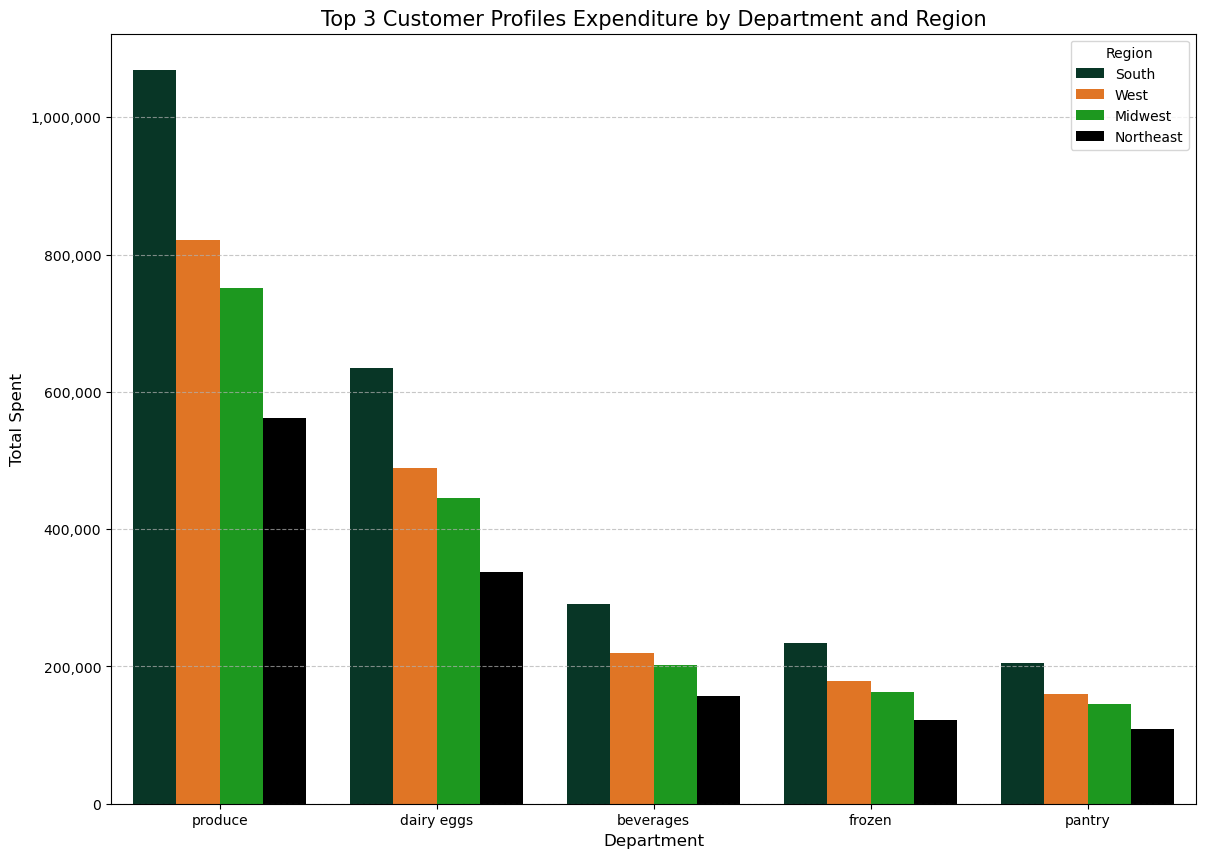

In [39]:
# Flatten the DataFrame for easier plotting (after your DataFrame has been created using the previous instructions)
flat_df = pivot_df.melt(id_vars=['department_name', 'Region'], var_name='customer_profile', value_name='total_spent')

# Sort the data based on the total spent within each department and region
flat_df.sort_values(by=['total_spent', 'Region'], ascending=[False, True], inplace=True)

# Plotting the bar chart
plt.figure(figsize=(14, 10))
top_3_customer_profiles_expenditure_by_department_and_region = sns.barplot(x='department_name', y='total_spent', hue='Region', data=flat_df, errorbar=None, palette=['#003E28', '#FF7106', '#09AC0B', 'black'])

plt.title('Top 3 Customer Profiles Expenditure by Department and Region', fontsize=15)
plt.xlabel('Department', fontsize=12)
plt.ylabel('Total Spent', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Region', loc='upper right')
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions_formatter))
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

### Customer Profile (Orders Interval)

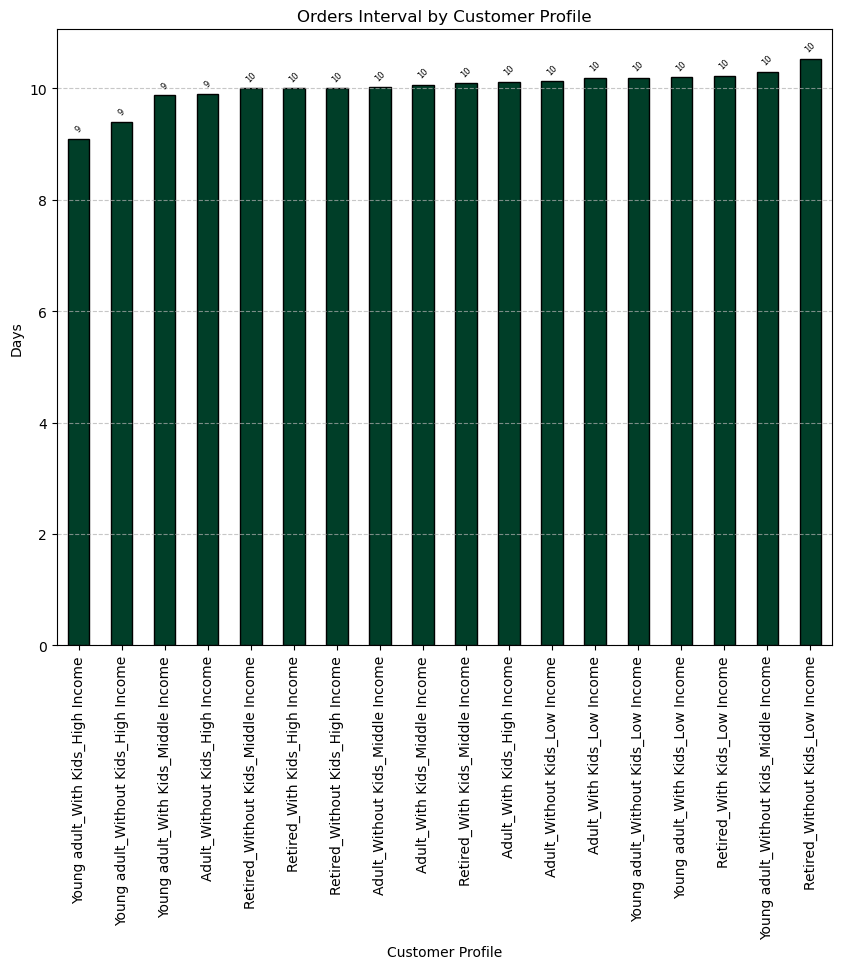

In [63]:
customer_profile_ordint_mean = df_high_activity_customers.groupby('customer_profile')['days_since_prior_order'].mean()
customer_profile_ordint_mean_sorted = customer_profile_ordint_mean.sort_values(ascending=True)

plt.figure(figsize=(10, 8))
bar_customer_profile_orders_interval = customer_profile_ordint_mean_sorted.plot.bar(
    title = 'Orders Interval by Customer Profile',
    xlabel = 'Customer Profile',
    ylabel = 'Days',
    color = '#003E28',
    edgecolor='black')
plt.xticks(rotation=90)
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions_formatter))
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of each bar
for bar in bar_customer_profile_orders_interval.patches:
    height = bar.get_height()
    label = '{:,}'.format(int(height))
    plt.annotate(label, 
                 (bar.get_x() + bar.get_width() / 2, height), 
                 ha='center',
                 xytext=(0, 5), textcoords='offset points', fontsize=6, rotation=45)

Across the board, the interval between orders among different customer profiles appears to be fairly consistent. It suggests that the frequency of orders is not significantly influenced by the specific characteristics such as age, presence of children, or income level. This uniformity in ordering frequency might indicate that other factors, like promotional cycles or habitual purchase behavior, are more influential in determining how often customers place orders.

### Customer Profile (Sales)

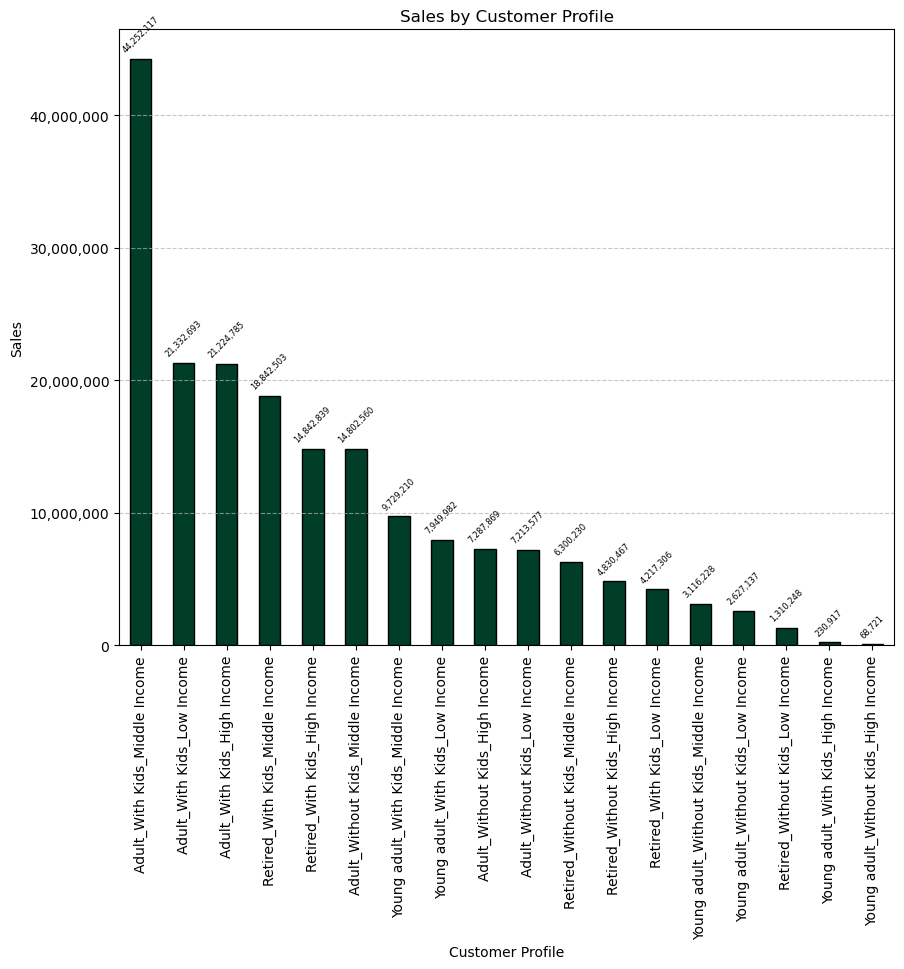

In [59]:
customer_profile_prices_sum = df_high_activity_customers.groupby('customer_profile')['prices'].sum()
customer_profile_prices_sum_sorted = customer_profile_prices_sum.sort_values(ascending=False)

plt.figure(figsize=(10, 8))
bar_customer_profile_sales = customer_profile_prices_sum_sorted.plot.bar(
    title = 'Sales by Customer Profile',
    xlabel = 'Customer Profile',
    ylabel = 'Sales',
    color = '#003E28',
    edgecolor='black')
plt.xticks(rotation=90)
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions_formatter))
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of each bar
for bar in bar_customer_profile_sales.patches:
    height = bar.get_height()
    label = '{:,}'.format(int(height))
    plt.annotate(label, 
                 (bar.get_x() + bar.get_width() / 2, height), 
                 ha='center',
                 xytext=(0, 5), textcoords='offset points', fontsize=6, rotation=45)

While the frequency of orders is consistent, the amount spent varies more widely across customer profiles. It's clear that certain customer profiles contribute more to sales than others, which could reflect differences in disposable income, household needs, or shopping preferences. For example, profiles such as "Adult, With Kids, High Income" are likely to have higher total sales due to the combination of purchasing for a larger family unit and having more disposable income.

In summary, while order frequency is relatively uniform across different customer profiles, the total sales and departmental expenditure show more variation, likely influenced by household composition, income levels, and regional factors. These insights could be valuable for tailoring marketing strategies, such as targeting higher-income profiles with promotions on family-sized or premium products, and focusing on the most popular departments to drive sales among the top spending profiles.

# Age/marital status analysis

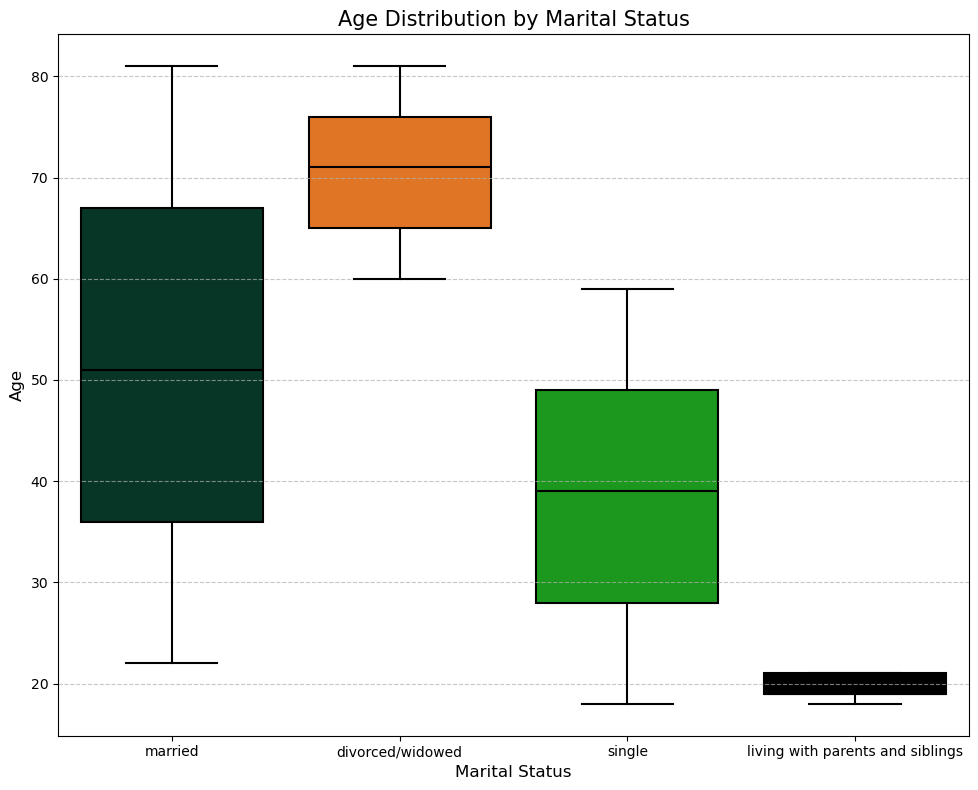

In [40]:
# Plot
plt.figure(figsize=(10, 8))
box_age_by_marital_status = sns.boxplot(x='marital_status', y='age', data=df_high_activity_customers, palette=['#003E28', '#FF7106', '#09AC0B', 'black'])

# Set title and labels
plt.title('Age Distribution by Marital Status', fontsize=15)
plt.xlabel('Marital Status', fontsize=12)
plt.ylabel('Age', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.tight_layout()
plt.show()

- Married individuals have an age distribution with a median in the 50s, with a wide interquartile range (IQR) from approximately 45 to 65, suggesting a broad range of ages within marriage.
- Divorced or widowed individuals tend to be older, with a median age above 60 and a narrower IQR, indicating less variability in age for this group.
- Single individuals have a median age around 40, with a large IQR similar to married individuals.
- People living with parents and siblings show as a black line, which suggests minimal to no data points, indicating that this category may not be significant for this analysis or that there are very few observations.


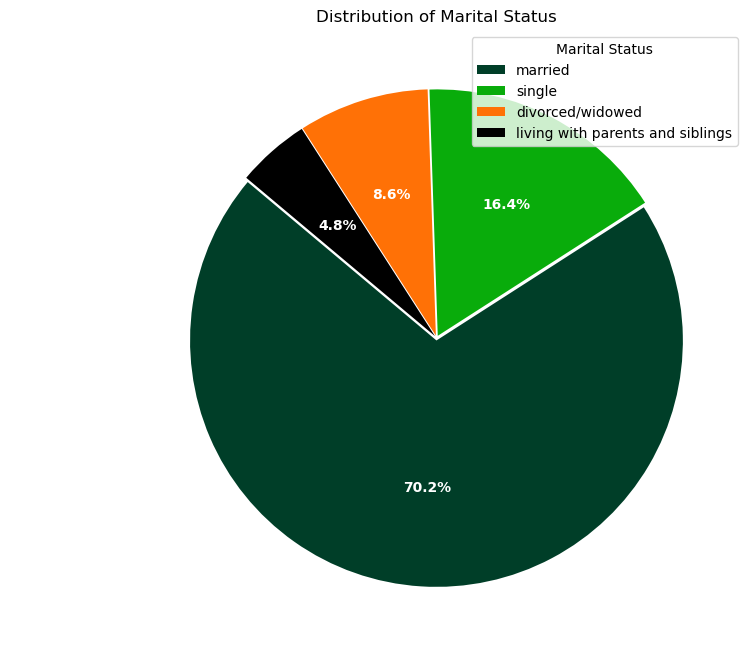

In [41]:
explode = (0.01, 0.01, 0.01, 0.01)  # only "explode" the first slice (married)
textprops = {"color":"white", "weight":"bold"}  # setting text properties for labels

# Calculate the distribution of marital status
marital_status_counts = df_high_activity_customers['marital_status'].value_counts()

# Define colors for each marital status
colors = {'married': '#003E28', 'divorced/widowed': '#FF7106', 'single': '#09AC0B', 'living with parents and siblings': 'black'}

# Match colors to the index of marital status
pie_colors = [colors[status] for status in marital_status_counts.index]

# Create pie chart
plt.figure(figsize=(8, 8))
plt.pie(marital_status_counts, labels=marital_status_counts.index, autopct='%1.1f%%', colors=pie_colors, startangle=140, explode=explode, textprops=textprops)
plt.legend(title='Marital Status', loc='upper right')
plt.title('Distribution of Marital Status')
plt.savefig(os.path.join(path, '04 Analysis','Visualizations', 'pie_distribution_of_marital_status.png'))
plt.show()

The vast majority are married (70.2%), followed by singles (16.4%), divorced/widowed (8.6%), and lastly, those living with parents and siblings (4.8%).

/Users/jorisjan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/jorisjan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


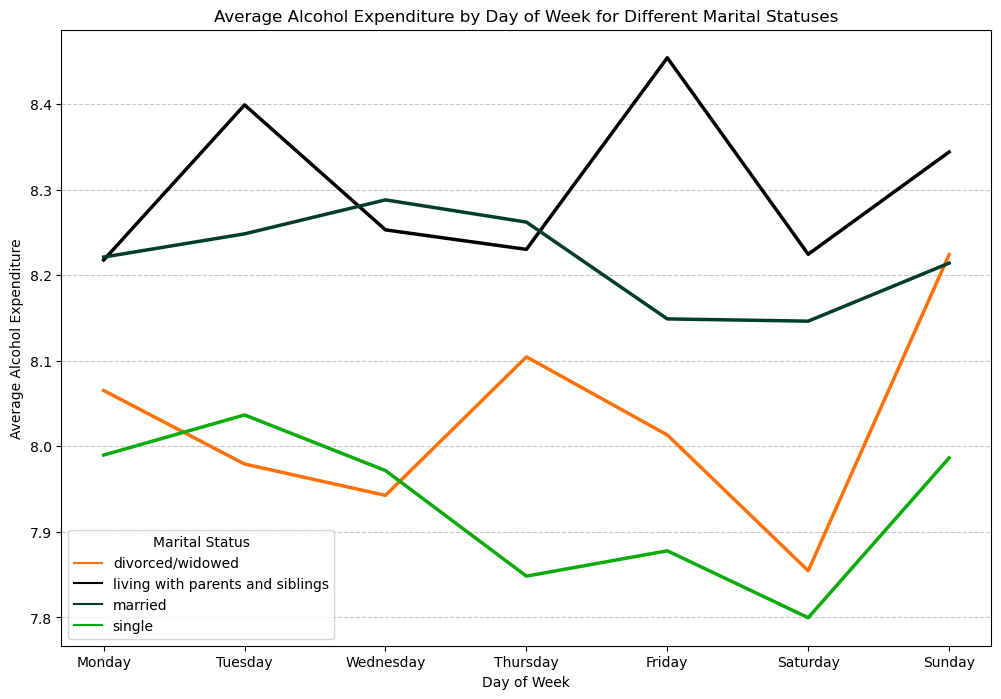

In [43]:
# Mapping of day numbers to day names
day_of_week_map = {0: 'Saturday', 1: 'Sunday', 2: 'Monday', 3: 'Tuesday', 4: 'Wednesday', 5: 'Thursday', 6: 'Friday'}

# Filter the DataFrame to include only rows with 'department_id' of 5 (alcohol)
df_alcohol = df_high_activity_customers[df_high_activity_customers['department_id'] == 5]

# Group by 'orders_day_of_week' and 'marital_status', then calculate the sum of 'prices'
average_prices = df_alcohol.groupby(['orders_day_of_week', 'marital_status'])['prices'].mean().reset_index()

# Replace the 'orders_day_of_week' numbers with day names using the mapping
average_prices['orders_day_of_week'] = average_prices['orders_day_of_week'].map(day_of_week_map)

# Order the days correctly from Monday to Sunday
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
average_prices['orders_day_of_week'] = pd.Categorical(average_prices['orders_day_of_week'], categories=ordered_days, ordered=True)

# Pivot the data to have 'orders_day_of_week' as the index and 'marital_status' categories as columns
average_prices_pivot = average_prices.pivot(index='orders_day_of_week', columns='marital_status', values='prices')

# Plot a line chart with separate lines for each marital status
plt.figure(figsize=(12, 8))
sns.lineplot(data=average_prices_pivot, palette={
    'married': '#003E28', 
    'divorced/widowed': '#FF7106', 
    'single': '#09AC0B', 
    'living with parents and siblings': 'black'
}, linewidth=2.5, dashes=False)

# Setting the labels and title
plt.xlabel('Day of Week')
plt.ylabel('Average Alcohol Expenditure')
plt.title('Average Alcohol Expenditure by Day of Week for Different Marital Statuses')
plt.legend(title='Marital Status')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Ensure the days are ordered on the x-axis
plt.xticks(range(len(ordered_days)), ordered_days)

# Show the plot
plt.savefig(os.path.join(path, '04 Analysis','Visualizations', 'line_alcohol_expenditure.png'))
plt.show()

- Divorced/widowed individuals show higher variability in alcohol expenditure throughout the week, with a peak around midweek.
- Those living with parents and siblings exhibit low variability and consistently lower expenditure, which might be influenced by the social dynamics of living with family.
- Married individuals' alcohol expenditure is generally stable across the week but shows a significant increase on Sundays.
- Single individuals’ expenditure on alcohol is relatively stable with a slight increase on weekends, which could reflect social patterns.


/Users/jorisjan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/jorisjan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


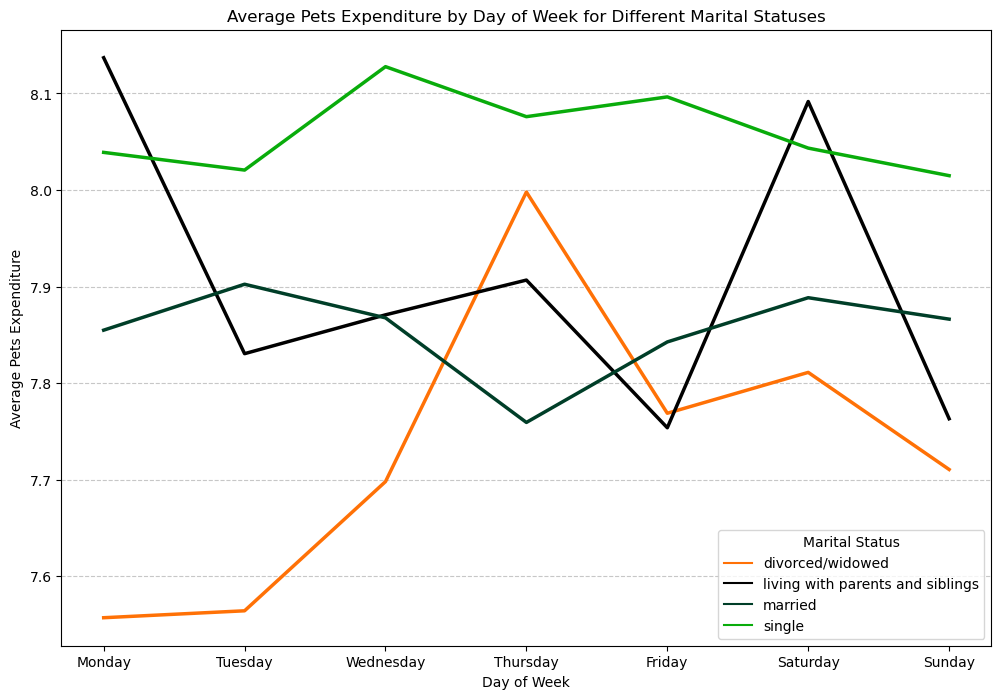

In [44]:
# Filter the DataFrame to include only rows with 'department_id' of 8 (pets)
df_pets = df_high_activity_customers[df_high_activity_customers['department_id'] == 8]

# Group by 'orders_day_of_week' and 'marital_status', then calculate the sum of 'prices'
average_prices = df_pets.groupby(['orders_day_of_week', 'marital_status'])['prices'].mean().reset_index()

# Replace the 'orders_day_of_week' numbers with day names using the mapping
average_prices['orders_day_of_week'] = average_prices['orders_day_of_week'].map(day_of_week_map)

# Order the days correctly from Monday to Sunday
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
average_prices['orders_day_of_week'] = pd.Categorical(average_prices['orders_day_of_week'], categories=ordered_days, ordered=True)

# Pivot the data to have 'orders_day_of_week' as the index and 'marital_status' categories as columns
average_prices_pivot = average_prices.pivot(index='orders_day_of_week', columns='marital_status', values='prices')

# Plot a line chart with separate lines for each marital status
plt.figure(figsize=(12, 8))
sns.lineplot(data=average_prices_pivot, palette={
    'married': '#003E28', 
    'divorced/widowed': '#FF7106', 
    'single': '#09AC0B', 
    'living with parents and siblings': 'black'
}, linewidth=2.5, dashes=False)

# Setting the labels and title
plt.xlabel('Day of Week')
plt.ylabel('Average Pets Expenditure')
plt.title('Average Pets Expenditure by Day of Week for Different Marital Statuses')
plt.legend(title='Marital Status')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Ensure the days are ordered on the x-axis
plt.xticks(range(len(ordered_days)), ordered_days)

# Show the plot
plt.savefig(os.path.join(path, '04 Analysis','Visualizations', 'line_pets_expenditure.png'))
plt.show()

- Spending on pets does not show a strong correlation with marital status, as the patterns are inconsistent across the groups.
- There's an observable increase in expenditure for married individuals on Saturday, which might suggest a tendency for family-related pet activities on weekends.


/Users/jorisjan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/jorisjan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


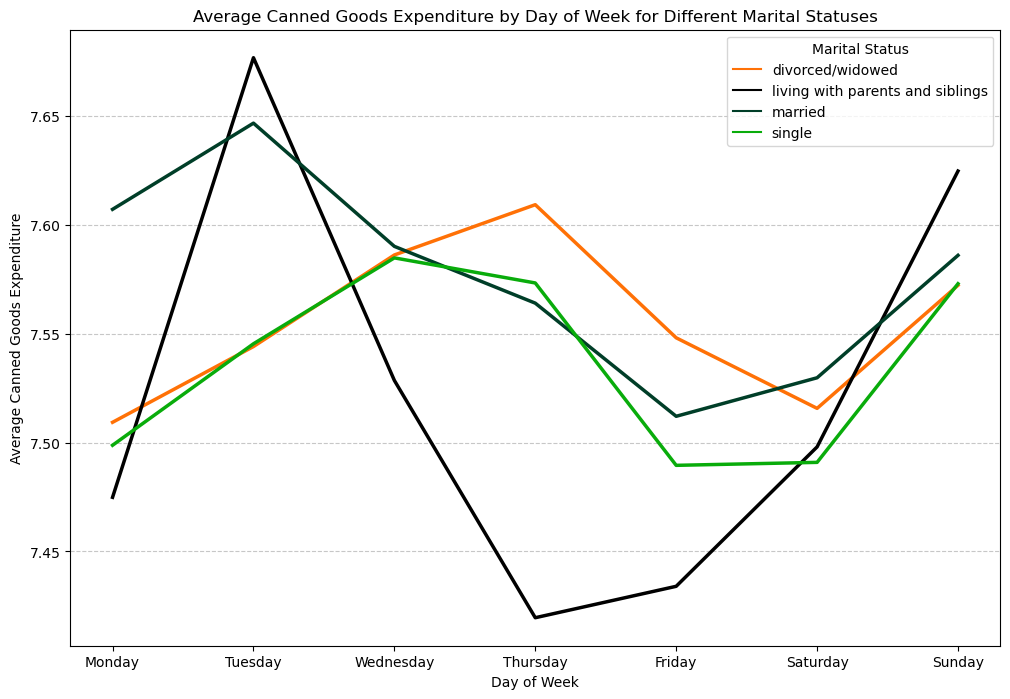

In [45]:
# Filter the DataFrame to include only rows with 'department_id' of 15 (canned goods)
df_canned_goods = df_high_activity_customers[df_high_activity_customers['department_id'] == 15]

# Group by 'orders_day_of_week' and 'marital_status', then calculate the sum of 'prices'
average_prices = df_canned_goods.groupby(['orders_day_of_week', 'marital_status'])['prices'].mean().reset_index()

# Replace the 'orders_day_of_week' numbers with day names using the mapping
average_prices['orders_day_of_week'] = average_prices['orders_day_of_week'].map(day_of_week_map)

# Order the days correctly from Monday to Sunday
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
average_prices['orders_day_of_week'] = pd.Categorical(average_prices['orders_day_of_week'], categories=ordered_days, ordered=True)

# Pivot the data to have 'orders_day_of_week' as the index and 'marital_status' categories as columns
average_prices_pivot = average_prices.pivot(index='orders_day_of_week', columns='marital_status', values='prices')

# Plot a line chart with separate lines for each marital status
plt.figure(figsize=(12, 8))
sns.lineplot(data=average_prices_pivot, palette={
    'married': '#003E28', 
    'divorced/widowed': '#FF7106', 
    'single': '#09AC0B', 
    'living with parents and siblings': 'black'
}, linewidth=2.5, dashes=False)

# Setting the labels and title
plt.xlabel('Day of Week')
plt.ylabel('Average Canned Goods Expenditure')
plt.title('Average Canned Goods Expenditure by Day of Week for Different Marital Statuses')
plt.legend(title='Marital Status')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Ensure the days are ordered on the x-axis
plt.xticks(range(len(ordered_days)), ordered_days)

# Show the plot
plt.savefig(os.path.join(path, '04 Analysis','Visualizations', 'line_canned_goods_expenditure.png'))
plt.show()

- Divorced/widowed and single individuals show similar patterns with peaks and troughs, suggesting no strong daily pattern linked to marital status.
- Married individuals have a more stable purchasing pattern with a slight increase on weekends.
- Individuals living with parents and siblings show a significant expenditure increase on Sunday, which could be related to joint family meals or preparation for the week.


/Users/jorisjan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/jorisjan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


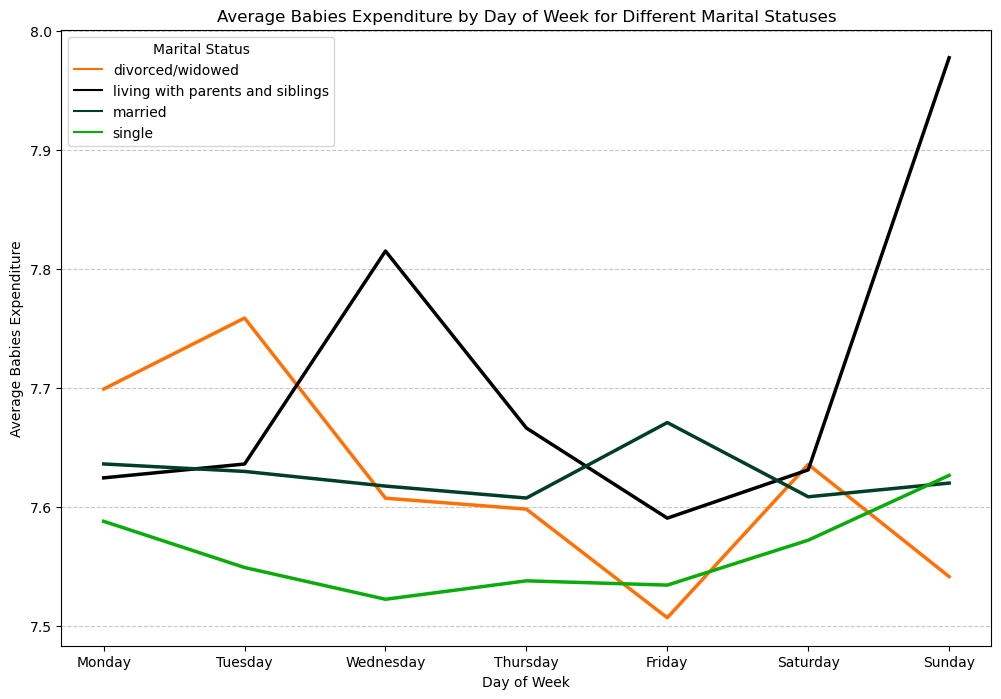

In [46]:
# Filter the DataFrame to include only rows with 'department_id' of 18 (babies)
df_babies = df_high_activity_customers[df_high_activity_customers['department_id'] == 18]

# Group by 'orders_day_of_week' and 'marital_status', then calculate the sum of 'prices'
average_prices = df_babies.groupby(['orders_day_of_week', 'marital_status'])['prices'].mean().reset_index()

# Replace the 'orders_day_of_week' numbers with day names using the mapping
average_prices['orders_day_of_week'] = average_prices['orders_day_of_week'].map(day_of_week_map)

# Order the days correctly from Monday to Sunday
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
average_prices['orders_day_of_week'] = pd.Categorical(average_prices['orders_day_of_week'], categories=ordered_days, ordered=True)

# Pivot the data to have 'orders_day_of_week' as the index and 'marital_status' categories as columns
average_prices_pivot = average_prices.pivot(index='orders_day_of_week', columns='marital_status', values='prices')

# Plot a line chart with separate lines for each marital status
plt.figure(figsize=(12, 8))
sns.lineplot(data=average_prices_pivot, palette={
    'married': '#003E28', 
    'divorced/widowed': '#FF7106', 
    'single': '#09AC0B', 
    'living with parents and siblings': 'black'
}, linewidth=2.5, dashes=False)

# Setting the labels and title
plt.xlabel('Day of Week')
plt.ylabel('Average Babies Expenditure')
plt.title('Average Babies Expenditure by Day of Week for Different Marital Statuses')
plt.legend(title='Marital Status')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Ensure the days are ordered on the x-axis
plt.xticks(range(len(ordered_days)), ordered_days)

# Show the plot
plt.savefig(os.path.join(path, '04 Analysis','Visualizations', 'line_babies.png'))
plt.show()

- Married individuals demonstrate a consistent increase in baby-related expenditure towards the weekend, which could be associated with family planning and the availability of time to shop for baby needs.
- Other marital statuses show less consistency and lower levels of expenditure on baby items, as expected, since baby needs are generally more relevant to married couples or those with children.


# Loyalty Analysis

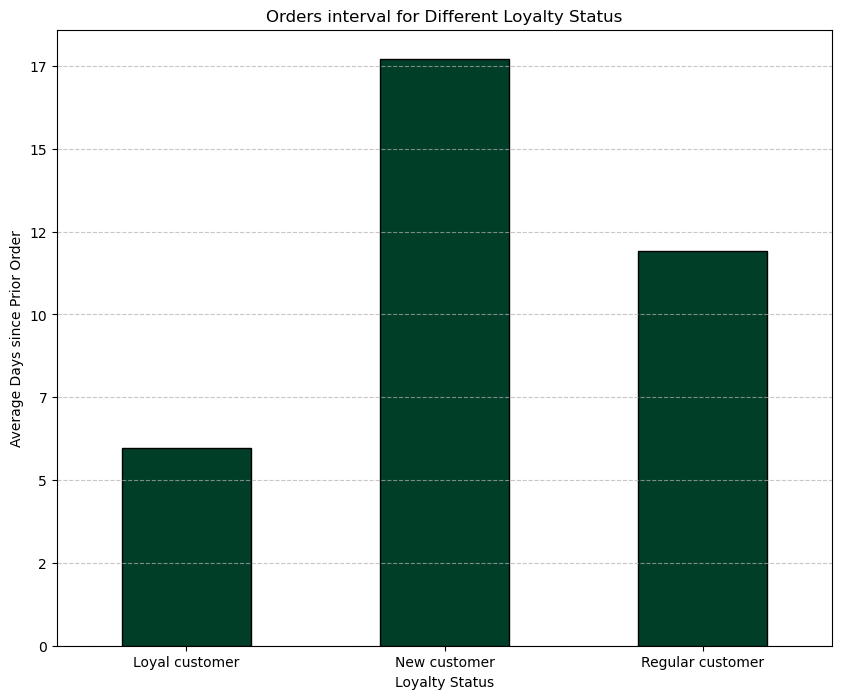

In [55]:
plt.figure(figsize=(10, 8))
bar_orders_interval_loyalty = df_high_activity_customers.groupby('loyalty_flag')['days_since_prior_order'].mean().plot.bar(
    title = 'Orders interval for Different Loyalty Status',
    xlabel = 'Loyalty Status',
    ylabel = 'Average Days since Prior Order',
    color = '#003E28',
    edgecolor='black')
plt.xticks(rotation=0)
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions_formatter))
plt.grid(axis='y', linestyle='--', alpha=0.7)

- Loyal customers have the shortest average interval between orders, which indicates that they place orders more frequently than other types of customers (around 6 days).
- New customers have the longest average interval between orders (around 17 days).
- Regular customers fall in the middle, with an average interval that seems to be roughly 12 days.


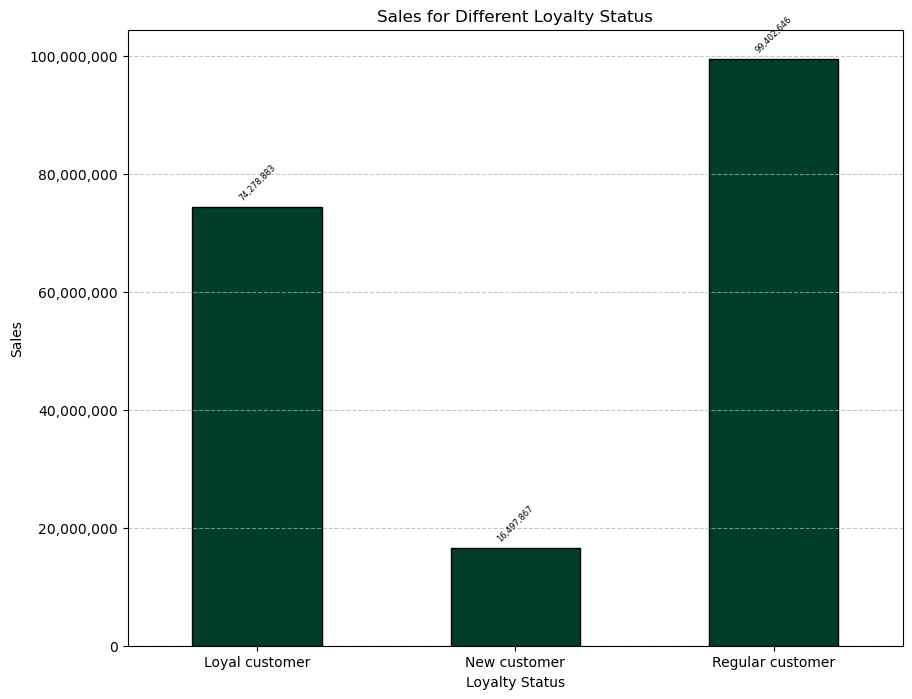

In [56]:
plt.figure(figsize=(10, 8))
bar_sales_loyalty = df_high_activity_customers.groupby('loyalty_flag')['prices'].sum().plot.bar(
    title = 'Sales for Different Loyalty Status',
    xlabel = 'Loyalty Status',
    ylabel = 'Sales',
    color = '#003E28',
    edgecolor='black')
plt.xticks(rotation=0)
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions_formatter))
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of each bar
for bar in bar_sales_loyalty.patches:
    height = bar.get_height()
    label = '{:,}'.format(int(height))
    plt.annotate(label, 
                 (bar.get_x() + bar.get_width() / 2, height), 
                 ha='center',
                 xytext=(0, 5), textcoords='offset points', fontsize=6, rotation=45)

- Loyal customers, despite ordering more frequently, do not have the highest total sales (around $74 million).
- Regular customers have the highest total sales, roughly $100 million, which suggests that even though they order less frequently than loyal customers, their orders are likely to be larger on average.
- New customers contribute the least to total sales, with sales around $15 million, which aligns with their status as the newest customer group and possibly smaller order sizes or fewer repeat purchases.

Conclusions:
- Loyal customers order the most frequently but do not necessarily spend the most. This could be indicative of loyal customers taking advantage of frequent, smaller purchases, possibly encouraged by loyalty programs or habitual purchases of necessities.
- Regular customers, while they order less frequently than loyal customers, contribute more to total sales. This suggests that regular customers may make larger purchases when they do order, which could be a sign of strategic buying habits such as bulk purchasing or selecting higher-value items.
- New customers are still in the early stages of their relationship with the company, as indicated by both the infrequent orders and lower total sales. This group may require targeted marketing efforts to increase their purchase frequency and value.

This data highlights the importance of understanding different customer segments to tailor marketing and sales strategies effectively. For instance, efforts to convert regular customers into loyal ones could be highly profitable given their high spending, and increasing the purchase frequency of loyal customers could lead to a significant boost in sales. For new customers, strategies might involve nurturing them with introductory offers or engaging them with the goal of turning them into regular or loyal customers over time.

# Exporting charts

In [146]:
bar_profile_distribution.figure.savefig(os.path.join(path, '04 Analysis','Visualizations', 'bar_profile_distribution.png'))
bar_top3_profiles_per_region.figure.savefig(os.path.join(path, '04 Analysis','Visualizations', 'bar_top3_profiles_per_region.png'))
bar_department_sales.figure.savefig(os.path.join(path, '04 Analysis','Visualizations', 'bar_department_sales.png'))
bar_top3_profiles_per_department.figure.savefig(os.path.join(path, '04 Analysis','Visualizations', 'bar_top3_profiles_per_department.png'))
top_3_customer_profiles_expenditure_by_department_and_region.figure.savefig(os.path.join(path, '04 Analysis','Visualizations', 'top_3_customer_profiles_expenditure_by_department_and_region.png'))
bar_orders_interval_loyalty.figure.savefig(os.path.join(path, '04 Analysis','Visualizations', 'bar_orders_interval_loyalty.png'))
bar_sales_loyalty.figure.savefig(os.path.join(path, '04 Analysis','Visualizations', 'bar_sales_loyalty.png'))
bar_customer_profile_sales.figure.savefig(os.path.join(path, '04 Analysis','Visualizations', 'bar_customer_profile_sales.png'))
bar_customer_profile_orders_interval.figure.savefig(os.path.join(path, '04 Analysis','Visualizations', 'bar_customer_profile_orders_interval.png'))